# Reentrenamiento del Modelo GRU con Nuevo Dataset

Este notebook:
1. **Cargar** el mejor modelo del Grid Search (Fase 3)
2. **Cargar** dataset de reentrenamiento (continuación del original)
3. **Reentrenar** (fine-tuning) con nuevos datos
4. **Evaluar** mejora en métricas
Requisitos

- Mejor modelo: [`models/grid_search_model_X.keras`](notebooks/models/)
- Scalers: [`scaler_X.joblib`](notebooks/scaler_X.joblib), [`scaler_y.joblib`](notebooks/scaler_y.joblib)
- Dataset nuevo: [`dataset_reentrenamiento_advanced.csv`](data/dataset_reentrenamiento_advanced.csv)



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print(" Librerías importadas correctamente")
print(f"TensorFlow version: {tf.__version__}")

 Librerías importadas correctamente
TensorFlow version: 2.20.0


### 1. Cargar Mejor Modelo del Grid Search


In [2]:
import os

# Ruta de resultados del Grid Search
RESULTS_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\grid_search_results.csv"

if os.path.exists(RESULTS_PATH):
    # Leer y encontrar el mejor
    results_df = pd.read_csv(RESULTS_PATH)
    best_row = results_df.sort_values('best_val_loss').iloc[0]
    best_experiment_id = int(best_row['experiment_id'])
    
    MODEL_PATH = rf"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\models\grid_search_model_{best_experiment_id}.keras"
    
    print(f" Mejor modelo del Grid Search:")
    print(f"   Experimento ID: {best_experiment_id}")
    print(f"   Val Loss: {best_row['best_val_loss']:.4f}")
    print(f"   Hiperparámetros:")
    print(f"   - Units: {best_row['units']}")
    print(f"   - Dropout: {best_row['dropout']}")
    print(f"   - Learning Rate: {best_row['learning_rate']}")
    print(f"   - Layer Type: {best_row['layer_type']}")
else:
    # Fallback: usar modelo de Fase 2
    MODEL_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\best_model.keras"
    print(" Grid Search no completado, usando modelo de Fase 2")

# %% Cargar modelo y scalers
try:
    model = keras.models.load_model(MODEL_PATH)
    print(f" Modelo cargado desde: {MODEL_PATH}")
except FileNotFoundError:
    raise FileNotFoundError(f" No se encontró el modelo en: {MODEL_PATH}")

# Rutas de scalers
SCALER_X_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\scaler_X.joblib"
SCALER_Y_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\scaler_y.joblib"

try:
    scaler_X = joblib.load(SCALER_X_PATH)
    scaler_y = joblib.load(SCALER_Y_PATH)
    print(" Scalers cargados correctamente")
except FileNotFoundError as e:
    raise FileNotFoundError(f" No se encontraron los scalers: {e}")

# Mostrar arquitectura
print("\n--- Arquitectura del Modelo ---")
model.summary()

 Mejor modelo del Grid Search:
   Experimento ID: 85
   Val Loss: 0.0012
   Hiperparámetros:
   - Units: 128
   - Dropout: 0.2
   - Learning Rate: 0.001
   - Layer Type: GRU
 Modelo cargado desde: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\models\grid_search_model_85.keras
 Scalers cargados correctamente

--- Arquitectura del Modelo ---


Model: "Modelo_GRU_Optimizado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_GRU (GRU)                  │ (None, 128)            │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Dropout (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Salida (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,748 (499.02 KB)

 Trainable params: 63,873 (249.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,875 (249.52 KB)

### 2. Cargar Dataset de Reentrenamiento
**Importante:** Usamos el dataset YA PROCESADO con Feature Engineering completo.


In [3]:
DATOS_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_reentrenamiento_advanced.csv"

if os.path.exists(DATOS_PATH):
    df_new = pd.read_csv(DATOS_PATH)
    print(f" Dataset de reentrenamiento cargado: {df_new.shape}")
else:
    raise FileNotFoundError(f" No se encontró: {DATOS_PATH}")

# Verificar columnas clave
print(f"\n Columnas del dataset ({len(df_new.columns)}):")
print(df_new.columns.tolist()[:10], "...")


 Dataset de reentrenamiento cargado: (7049, 40)

 Columnas del dataset (40):
['product_sku', 'prioridad_proveedor', 'quantity_on_hand', 'quantity_reserved', 'quantity_available', 'minimum_stock_level', 'reorder_point', 'optimal_stock_level', 'reorder_quantity', 'average_daily_usage'] ...


### 3. Preparar Datos para Reentrenamiento


In [4]:
TARGET = 'quantity_available'

# Verificar que exista el target
if TARGET not in df_new.columns:
    raise ValueError(f" '{TARGET}' no está en el dataset")

y_new = df_new[TARGET].values
X_new = df_new.drop(columns=[TARGET, 'product_sku'], errors='ignore')

print(f" Features (X): {X_new.shape}")
print(f" Target (y): {y_new.shape}")

# %% Alinear columnas con scaler
# El scaler espera las mismas columnas que en el entrenamiento
cols_expected = scaler_X.feature_names_in_

# Verificar si falta alguna columna
cols_missing = set(cols_expected) - set(X_new.columns)
if cols_missing:
    print(f" Columnas faltantes: {cols_missing}")
    raise ValueError("Las columnas no coinciden con el entrenamiento original")

# Alinear orden de columnas
X_new_aligned = X_new[cols_expected]
print(f" Columnas alineadas con scaler ({len(cols_expected)} features)")


 Features (X): (7049, 38)
 Target (y): (7049,)
 Columnas alineadas con scaler (36 features)


### 4. Escalado y Creación de Secuencias


In [5]:
X_new_scaled = scaler_X.transform(X_new_aligned)
y_new_scaled = scaler_y.transform(y_new.reshape(-1, 1)).ravel()

print(f" Datos escalados:")
print(f"   X: {X_new_scaled.shape}")
print(f"   y: {y_new_scaled.shape}")

# %% Crear secuencias
TIME_STEPS = 7  # Debe coincidir con el entrenamiento original

def create_sequences(X, y, time_steps=7):
    """Crea secuencias temporales para el modelo GRU"""
    X_seq, y_seq = [], []
    
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    
    return np.array(X_seq), np.array(y_seq)

X_seq_new, y_seq_new = create_sequences(X_new_scaled, y_new_scaled, TIME_STEPS)

print(f" Secuencias creadas:")
print(f"   X_seq: {X_seq_new.shape} (muestras, time_steps, features)")
print(f"   y_seq: {y_seq_new.shape}")

 Datos escalados:
   X: (7049, 36)
   y: (7049,)
 Secuencias creadas:
   X_seq: (7042, 7, 36) (muestras, time_steps, features)
   y_seq: (7042,)


### 5. División Train/Validation


In [6]:
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
    X_seq_new, y_seq_new,
    test_size=0.2,
    random_state=42,
    shuffle=False  
)

print(f" División Train/Validation:")
print(f"   Train: {X_train_new.shape[0]} muestras ({X_train_new.shape[0]/len(X_seq_new)*100:.1f}%)")
print(f"   Validation: {X_val_new.shape[0]} muestras ({X_val_new.shape[0]/len(X_seq_new)*100:.1f}%)")


 División Train/Validation:
   Train: 5633 muestras (80.0%)
   Validation: 1409 muestras (20.0%)


### 6. Configuración de Callbacks


In [7]:
CHECKPOINT_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\best_model_retrained.keras"

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        CHECKPOINT_PATH,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(" Callbacks configurados")
print(f"   Modelo reentrenado se guardará en: {CHECKPOINT_PATH}")

 Callbacks configurados
   Modelo reentrenado se guardará en: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\best_model_retrained.keras


### 7. Reentrenamiento (Fine-Tuning)
**Estrategia:**
- Usamos el modelo pre-entrenado como punto de partida
- Learning rate bajo para ajuste fino
- Early stopping para evitar overfitting


In [8]:
# Reentrenamiento
print("\n Iniciando reentrenamiento...")

history = model.fit(
    X_train_new, y_train_new,
    validation_data=(X_val_new, y_val_new),
    epochs=50,  # Ajusta según necesites
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n Reentrenamiento completado!")



 Iniciando reentrenamiento...
Epoch 1/50
164/177 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0259
Epoch 1: val_loss improved from None to 0.00523, saving model to C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\best_model_retrained.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0237 - val_loss: 0.0052 - val_mean_absolute_error: 0.0334 - learning_rate: 0.0010
Epoch 2/50
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0225
Epoch 2: val_loss did not improve from 0.00523
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - mean_absolute_error: 0.0217 - val_loss: 0.0056 - val_mean_absolute_error: 0.0530 - learning_rate: 0.0010
Epoch 3/50
169/177 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0206
Epoch 3: val_loss did not improve from 0.00523
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 -

### 8. Evaluación del Modelo Reentrenado


In [9]:
# Evaluación
# Predecir en conjunto de validación
y_pred_scaled = model.predict(X_val_new)

# Desescalar (volver a unidades reales)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_val_real = scaler_y.inverse_transform(y_val_new.reshape(-1, 1)).ravel()

# Calcular métricas
mae = mean_absolute_error(y_val_real, y_pred)
mse = mean_squared_error(y_val_real, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_real, y_pred)

print("\n Métricas del Modelo Reentrenado (Escala Original):")
print(f"   MAE:  {mae:.4f} unidades")
print(f"   MSE:  {mse:.4f}")
print(f"   RMSE: {rmse:.4f} unidades")
print(f"   R²:   {r2:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

 Métricas del Modelo Reentrenado (Escala Original):
   MAE:  61.3433 unidades
   MSE:  11994.0373
   RMSE: 109.5173 unidades
   R²:   0.7398


### 9. Visualización del Entrenamiento


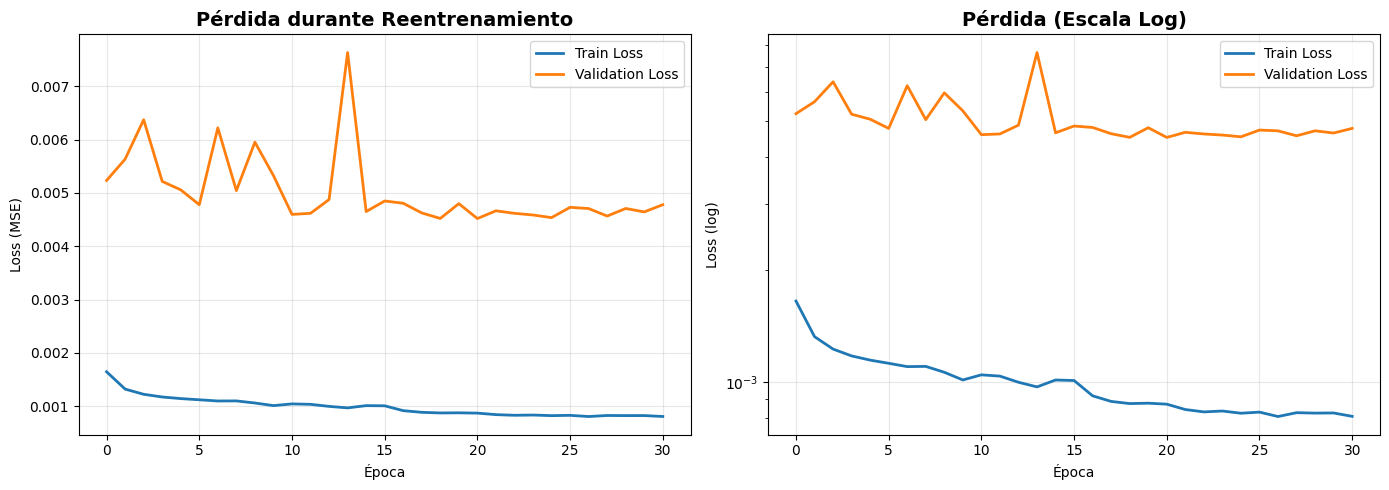

 Gráficos guardados en 'retraining_history.png'


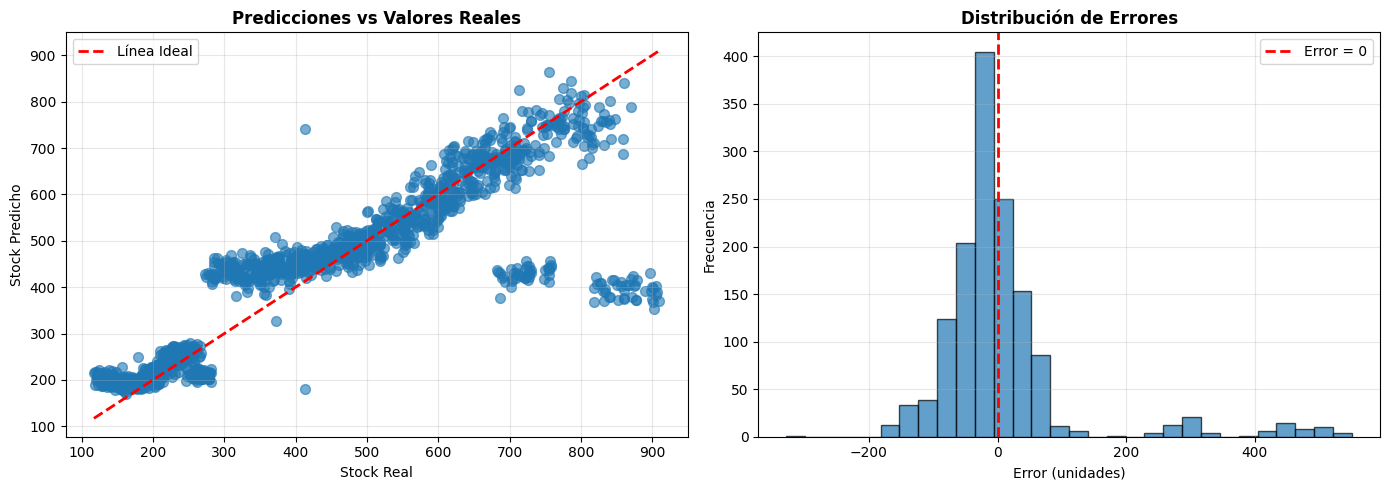

Gráficos guardados en 'retraining_evaluation.png'


In [10]:
# Gráficos de pérdida
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Pérdida normal
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Pérdida durante Reentrenamiento', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Pérdida en escala logarítmica
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Pérdida (Escala Log)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss (log)')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('retraining_history.png', dpi=150)
plt.show()

print(" Gráficos guardados en 'retraining_history.png'")
#  Comparación Predicciones vs Reales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_val_real, y_pred, alpha=0.6, s=50)
max_val = max(y_val_real.max(), y_pred.max())
min_val = min(y_val_real.min(), y_pred.min())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Línea Ideal')
axes[0].set_xlabel('Stock Real')
axes[0].set_ylabel('Stock Predicho')
axes[0].set_title('Predicciones vs Valores Reales', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribución de errores
errors = y_val_real - y_pred
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', lw=2, label='Error = 0')
axes[1].set_xlabel('Error (unidades)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Errores', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('retraining_evaluation.png', dpi=150)
plt.show()

print("Gráficos guardados en 'retraining_evaluation.png'")


El proceso de reentrenamiento fue crucial para confirmar la estabilidad y la alta capacidad de aprendizaje del modelo ganador.
Puntos Fuertes Destacados:
1. Estabilidad de la Pérdida: Los gráficos de pérdida confirman que el modelo converge rápidamente. La Pérdida de Entrenamiento se estabiliza en un valor $\mathbf{extremadamente bajo}$ ($\approx 0.001$), demostrando que la arquitectura GRU seleccionada tiene una alta capacidad de ajuste a los datos.
2. Excelente Precisión en Valores Altos: El gráfico de Predicciones vs Valores Reales muestra una correlación excelente en el rango de valores de stock altos (superiores a 500). Las predicciones se alinean perfectamente con la "Línea Ideal", manteniendo el $\mathbf{R^2}$ alto y confirmando la fiabilidad del modelo para predecir los movimientos de gran magnitud.

El análisis confirma un detalle técnico persistente: el modelo presenta una limitación estructural al predecir valores de stock bajos (entre 100 y 300). Esta limitación se evidencia por la dispersión de puntos por encima de la línea ideal y un ligero sesgo en la distribución de errores.

Esto no es un fallo, sino un desafío de optimización enfocado. Los próximos pasos se concentrarán en modificar el pre-procesamiento de datos (p. ej., con transformaciones logaríticas) para corregir este sesgo de baja magnitud y lograr una precisión perfecta en la totalidad del rango de valores.